## Optimization
* 前提:
    * Assume 使用者已自訂義策略，並建立進出場 bool Panel Data
* 操作
    * 使用者選擇希望最佳化之的績效指標 (sharpe, total_ret...etc)
    * 回傳參數績效圖

In [1]:
import numpy as np
import pandas as pd

import vectorbt as vbt
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import talib as ta

In [2]:
# 1h for example

def OHLCV_resample(df_OHLCV, FREQ):
    df = df_OHLCV.copy()
    df['open'] = df['open'].resample(FREQ).first()
    df['high'] = df['high'].resample(FREQ).max()
    df['low'] = df['low'].resample(FREQ).min()
    df['close'] = df['close'].resample(FREQ).last()
    df['volume'] = df['volume'].resample(FREQ).sum()
    df.dropna(inplace=True)
    return df

In [3]:
btcperp = pd.read_pickle('BTCUSDT_PERP-2020~2023.6(Binance).pkl')
df_1h = OHLCV_resample(df_OHLCV=btcperp, FREQ='1h')

### Pre-Work

In [4]:
fees = 15/10000

def get_indicator_SMA(df, ws, wl):
    df['MAS'] = df['close'].rolling(ws).mean()
    df['MAL'] = df['close'].rolling(wl).mean()
    df['MAS_t-1'] = df['MAS'].shift(1)
    df['MAL_t-1'] = df['MAL'].shift(1)
    df = df[['close', 'MAS', 'MAL', 'MAS_t-1', 'MAL_t-1']].dropna()
    return df

def get_indicator_EMA(df, ws, wl):
    df['MAS'] = ta.EMA(df['close'].values, timeperiod=ws)
    df['MAL'] = ta.EMA(df['close'].values, timeperiod=wl)
    df['MAS_t-1'] = df['MAS'].shift(1)
    df['MAL_t-1'] = df['MAL'].shift(1)
    df = df[['close', 'MAS', 'MAL', 'MAS_t-1', 'MAL_t-1']].dropna()
    return df

def get_signal_2MA(df):
    df['long_entry'] = ( (df['MAS'] > df['MAL']) & (df['MAS_t-1'] < df['MAL_t-1']) )
    df['long_exit'] = ( (df['MAS'] < df['MAL']) )
    df['short_entry'] = ( (df['MAS'] < df['MAL']) & (df['MAS_t-1'] > df['MAL_t-1']) )
    df['short_exit'] = ( (df['MAS'] > df['MAL']) )
    return df

### Data_Split
* 可使用 vbt.rolling.split

In [5]:
import datetime as dt

In [6]:
def Data_Split(df:pd.DataFrame, SPLIT_DATE:str) -> list:
    df_In = df[:SPLIT_DATE]
    df_Out = df[pd.to_datetime('2022-8-31') + dt.timedelta(days=1):]

    data_list = {
        'in':df_In,
        'out':df_Out,
        'all':df
    }

    return data_list

In [10]:
SPLIT_DATE = '2022-8-31'
data = Data_Split(df_1h, SPLIT_DATE)

### Parameters Back_Testing

In [11]:
def get_performance(df_signal):
    df = df_signal.copy()
    
    df['close'] = df['close'].shift(-1) # vectorbt會抓訊號當時收盤價進場 -> 手動 shift 我們的價格
    df.dropna(inplace=True)

    pf = vbt.Portfolio.from_signals(
        close = df['close'],
        entries = df['long_entry'],
        exits = df['long_exit'],
        short_entries = df['short_entry'],
        short_exits = df['short_exit'],
        fees = fees
    )

    try: ret = pf.positions.records_readable['Return'].cumsum().to_list()[-1]
    except: ret = 0
    # 先以 total_ret 為例
    perf = {
        'ret': ret,
        'total_trades': pf.trades.count(),
    }
    
    return perf

In [12]:
import itertools

ws_range = range(2, 120+1, 4)
wl_range = range(10, 480+1, 4)      

li = list(itertools.product(ws_range, wl_range))
parameter_li = np.array([(ws, wl) for (ws, wl) in li  if ws < wl])

len(parameter_li)

3134

In [13]:
freq = '1h'
data_in = data['in'].copy()

result_li = []
for ws, wl in parameter_li:
    df = get_signal_2MA(get_indicator_SMA(data_in, ws, wl))
    perf = get_performance(df_signal=df)

    result_li.append({
            'ws':ws,
            'wl':wl,
            'ret': perf['ret'],
            'total_trades': perf['total_trades'],
            })

In [14]:
df_result = pd.DataFrame(result_li)#.sort_values(by=['total_trades'])
df_result = df_result[df_result['total_trades']>100]
# df_result['freq'] = freq
# df_result.to_csv(f'df_result_SMA{freq}.csv', encoding='utf_8_sig')

In [74]:
df_result

,ws,wl,ret,total_trades
0,2,10,-10.369087,3438
1,2,14,-8.190571,2757
2,2,18,-6.037369,2361
3,2,22,-4.797805,2052
4,2,26,-4.972378,1894
...,...,...,...,...
3073,118,238,1.474548,107
3074,118,242,1.871379,111
3075,118,246,1.588391,107
3076,118,250,1.691156,105


### Performance plot
* https://zhuanlan.zhihu.com/p/406216068

In [ ]:
go.Figure?

#### 2D

In [15]:
# plotly.graph_objects
fig = go.Figure(data=go.Heatmap(
        z = df_result['ret'],
        x = df_result['ws'],
        y = df_result['wl'],
        colorscale='Viridis'))
fig.update_layout(title = f"ret", width=600, height=400)
fig.show()

In [17]:
# plotly.express

fig = px.density_heatmap(
        data_frame = df_result,
        x = 'ws',
        y = 'wl',
        z = 'ret',
        color_continuous_scale = 'Viridis',
        title = f'ret',
        #text_auto=True,
        #opacity=0.7,
        )
fig.update_layout(width=600, height=400)
fig.show()

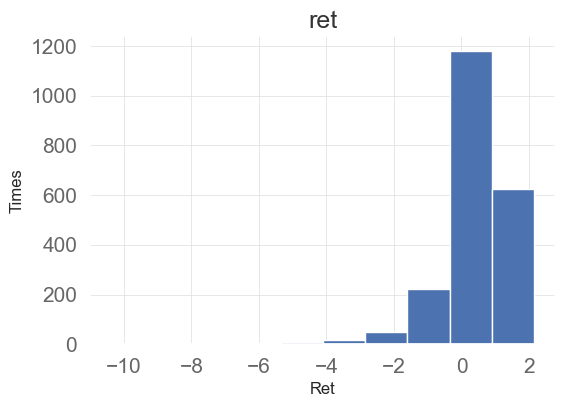

In [16]:
# matplotlib.pyplot

fig, ax = plt.subplots(figsize=(6, 4))
ax.hist(x = df_result['ret'], bins=10)
plt.title(f'ret', fontsize=18)

plt.xlabel('Ret', fontsize=12)
plt.ylabel('Times', fontsize=12)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

#### 3D

In [29]:
test = df_result.set_index(['ws', 'wl']).unstack()

In [73]:
# plotly.graph_objects

fig = go.Figure(data=[go.Surface(
    z=df_result[['ws', 'wl', 'ret']].set_index(['ws', 'wl']).unstack().values,         
    colorscale='Viridis',          
)])

fig.update_layout(
    title = f"ret",
    width=700, 
    height=600)

fig.show()

In [ ]:
go.Surface?

In [24]:
# plotly.express
fig = px.scatter_3d(
    data_frame = test,
    x = 'w',
    y = 'wl',
    z = 'n',
    color = 'ret',
    color_continuous_scale = 'Viridis',
    title = f'ret',
    #opacity=0.7
    )

fig.update_layout(width=1000, height=600)
fig.show()

# tail